In [1]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import json
import pandas as pd
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

%matplotlib inline


D:\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
### Sentiment Analysis

def sentimentanalysis(train):

    sid = SentimentIntensityAnalyzer()
    summary = {"positive":0,"neutral":0,"negative":0}
    sentiments = []

    for i in range(len(train)): 
        ss = sid.polarity_scores(train['text'][i])
        if ss["compound"] == 0.0: 
            summary["neutral"] +=1
            sentiments.append('neutral')
        elif ss["compound"] > 0.0:
            summary["positive"] +=1
            sentiments.append('positive')
        else:
            summary["negative"] +=1
            sentiments.append('negative')
    print(summary)

    train['sentiments'] = sentiments

    return train

### Wordcloud

def createwordcloud(train, figname, lower = None):

    if lower == None:
        alltexts = " ".join(review for review in train['text'])
    else:
        alltexts = " ".join(review for review in train['text_lower'])

    wordcloud = WordCloud(
        background_color = 'white',
        width = 3000,
        height = 2000,
        max_words = 200,
        stopwords = STOPWORDS).generate(str(alltexts))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(figname)

### Build up table

# Time group

def labelweek(row):

	if '分鐘' in row['time']:
		return 6
	if '小時' in row['time']:
		return 6
	if '天' in row['time']:
		return 6
	if '月' in row['time']:
		return 1
	if '週' in row['time']:
		return 6 - row['time_num']

	return -1


In [3]:
inputjsonfile = 'endgametra1.json'
data_json = [json.loads(line) for line in open(inputjsonfile, 'r', encoding = 'utf8')]

### panda dataframe

train = pd.DataFrame.from_dict(data_json)

# Text processing

train['text'] = train['text'].replace("\s\ufeff", "")
train['text_lower_nospace'] = train['text'].str.lower().str.replace(" ","")

# Week group

train['time_num'] = train['time'].str.extract('(\d+)')
train['time_num'] = pd.to_numeric(train['time_num'], errors='coerce')
train['week'] = train.apply (lambda row: labelweek(row), axis=1).astype('int')

# Release group

train['Release'] = np.where(train['week']==6, 1, 0)

# Delete other information

del train['author']
del train['cid']
del train['time']
del train['time_num']

In [26]:
##### Add analysis - character analysis

## Input character data

Characters = pd.read_csv('Marvel_Characters.csv', header=None).rename(columns={0:'character',1:'names'})  
Characters['names'] = Characters['names'].str.replace(" ","").str.lower()

namestolist = Characters['names'].tolist()
finalnamelist = []
namestolist[0].splitlines()

for i in range(len(namestolist)):
    finalnamelist.append(namestolist[i].splitlines())
finalnamelist[1].remove('don')
finalnamelist[9].remove('stan')

## Build character data

charactermentioned = pd.DataFrame(np.zeros([len(train),len(namestolist)])) # Create 30 columns for 30 characters

for i in range(len(finalnamelist)): # Find matched
    charactermentioned[i] = train['text_lower_nospace'].str.contains('|'.join(finalnamelist[i]))    

for i in range(len(Characters)): # Rename
    charactermentioned.rename(columns={i:Characters.iloc[i]['character']}, inplace=True)
    
charactermentioned['Release'] = train['Release'] # Add release information

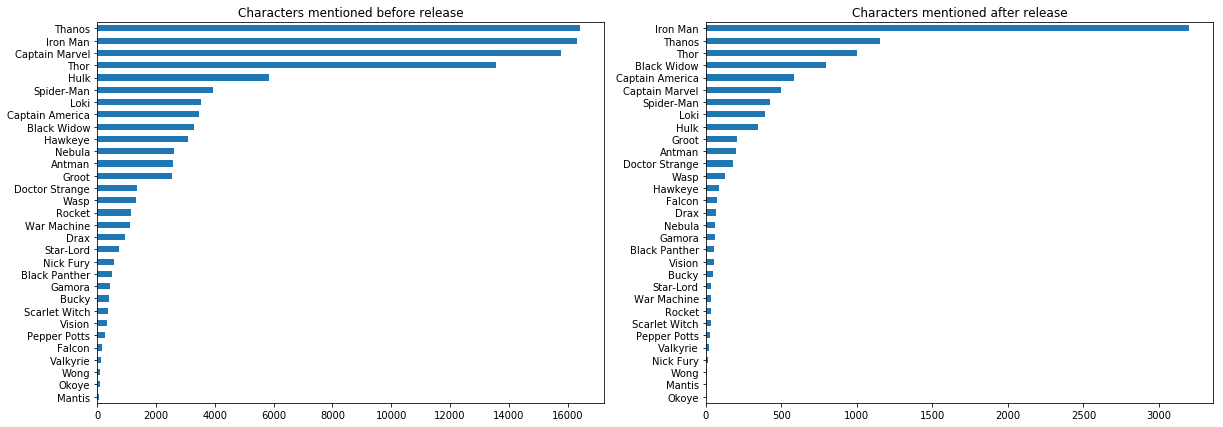

In [27]:
fig, axs = plt.subplots(1,2,figsize=(20,7))
charactermentioned.groupby('Release').get_group(1).sum().drop('Release').sort_values().plot(kind='barh',ax=axs[1], title='Characters mentioned after release')  
charactermentioned.groupby('Release').get_group(0).sum().drop('Release').sort_values().plot(kind='barh',ax=axs[0], title='Characters mentioned before release')
plt.savefig('PopularityofCharcs.jpg')

In [21]:
train.groupby('week').count()/len(train)

text  text_lower_nospace   Release  sentiments
week                                                    
1     0.888074            0.888074  0.888074    0.888074
2     0.004238            0.004238  0.004238    0.004238
3     0.014554            0.014554  0.014554    0.014554
4     0.010563            0.010563  0.010563    0.010563
5     0.016770            0.016770  0.016770    0.016770
6     0.065801            0.065801  0.065801    0.065801

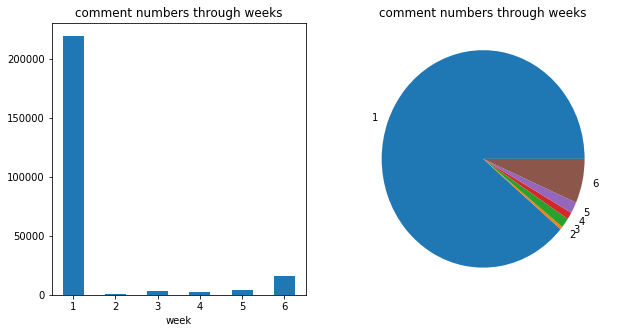

In [19]:
## Total comments analysis

fig, axs = plt.subplots(1,2,figsize=(10,5))
train.groupby('week').count()['text'].plot(kind='bar',title='comment numbers through weeks', ax=axs[0], rot=0)
train.groupby('week').count()['text'].plot(kind='pie',title='comment numbers through weeks', ax=axs[1])
plt.ylabel('')
plt.savefig('Comment_nums.jpg')

In [7]:
### Add analysis - sentiment analysis

train = sentimentanalysis(train)

{'positive': 74673, 'neutral': 134092, 'negative': 38041}


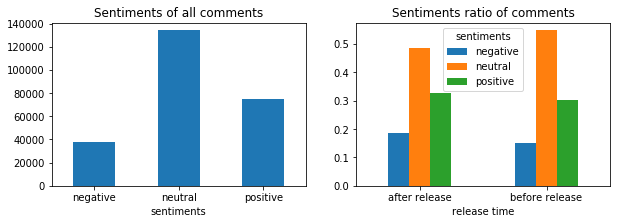

In [8]:
sentiment_groups = train.groupby(['Release','sentiments']).count().reset_index().drop('week', axis=1).rename(columns={'text':'count'})
comment_release = train.groupby('Release').count()['text']
sentiment_groups['sentRatio'] = np.where(sentiment_groups['Release']==1, sentiment_groups['count']/comment_release[1],  sentiment_groups['count']/comment_release[0])

fig, axs = plt.subplots(1,2, figsize=(10,3))
sentiment_groups.groupby('sentiments').sum()['count'].plot(kind='bar', ax=axs[0], title='Sentiments of all comments',rot=0)
sentiment_groups['release time'] = np.where(sentiment_groups['Release']==1, 'after release', 'before release')
sentiment_groups.pivot(index='release time', columns='sentiments', values='sentRatio').plot(kind='bar', ax=axs[1], title='Sentiments ratio of comments',rot=0)
plt.savefig('Sentiments.jpg')

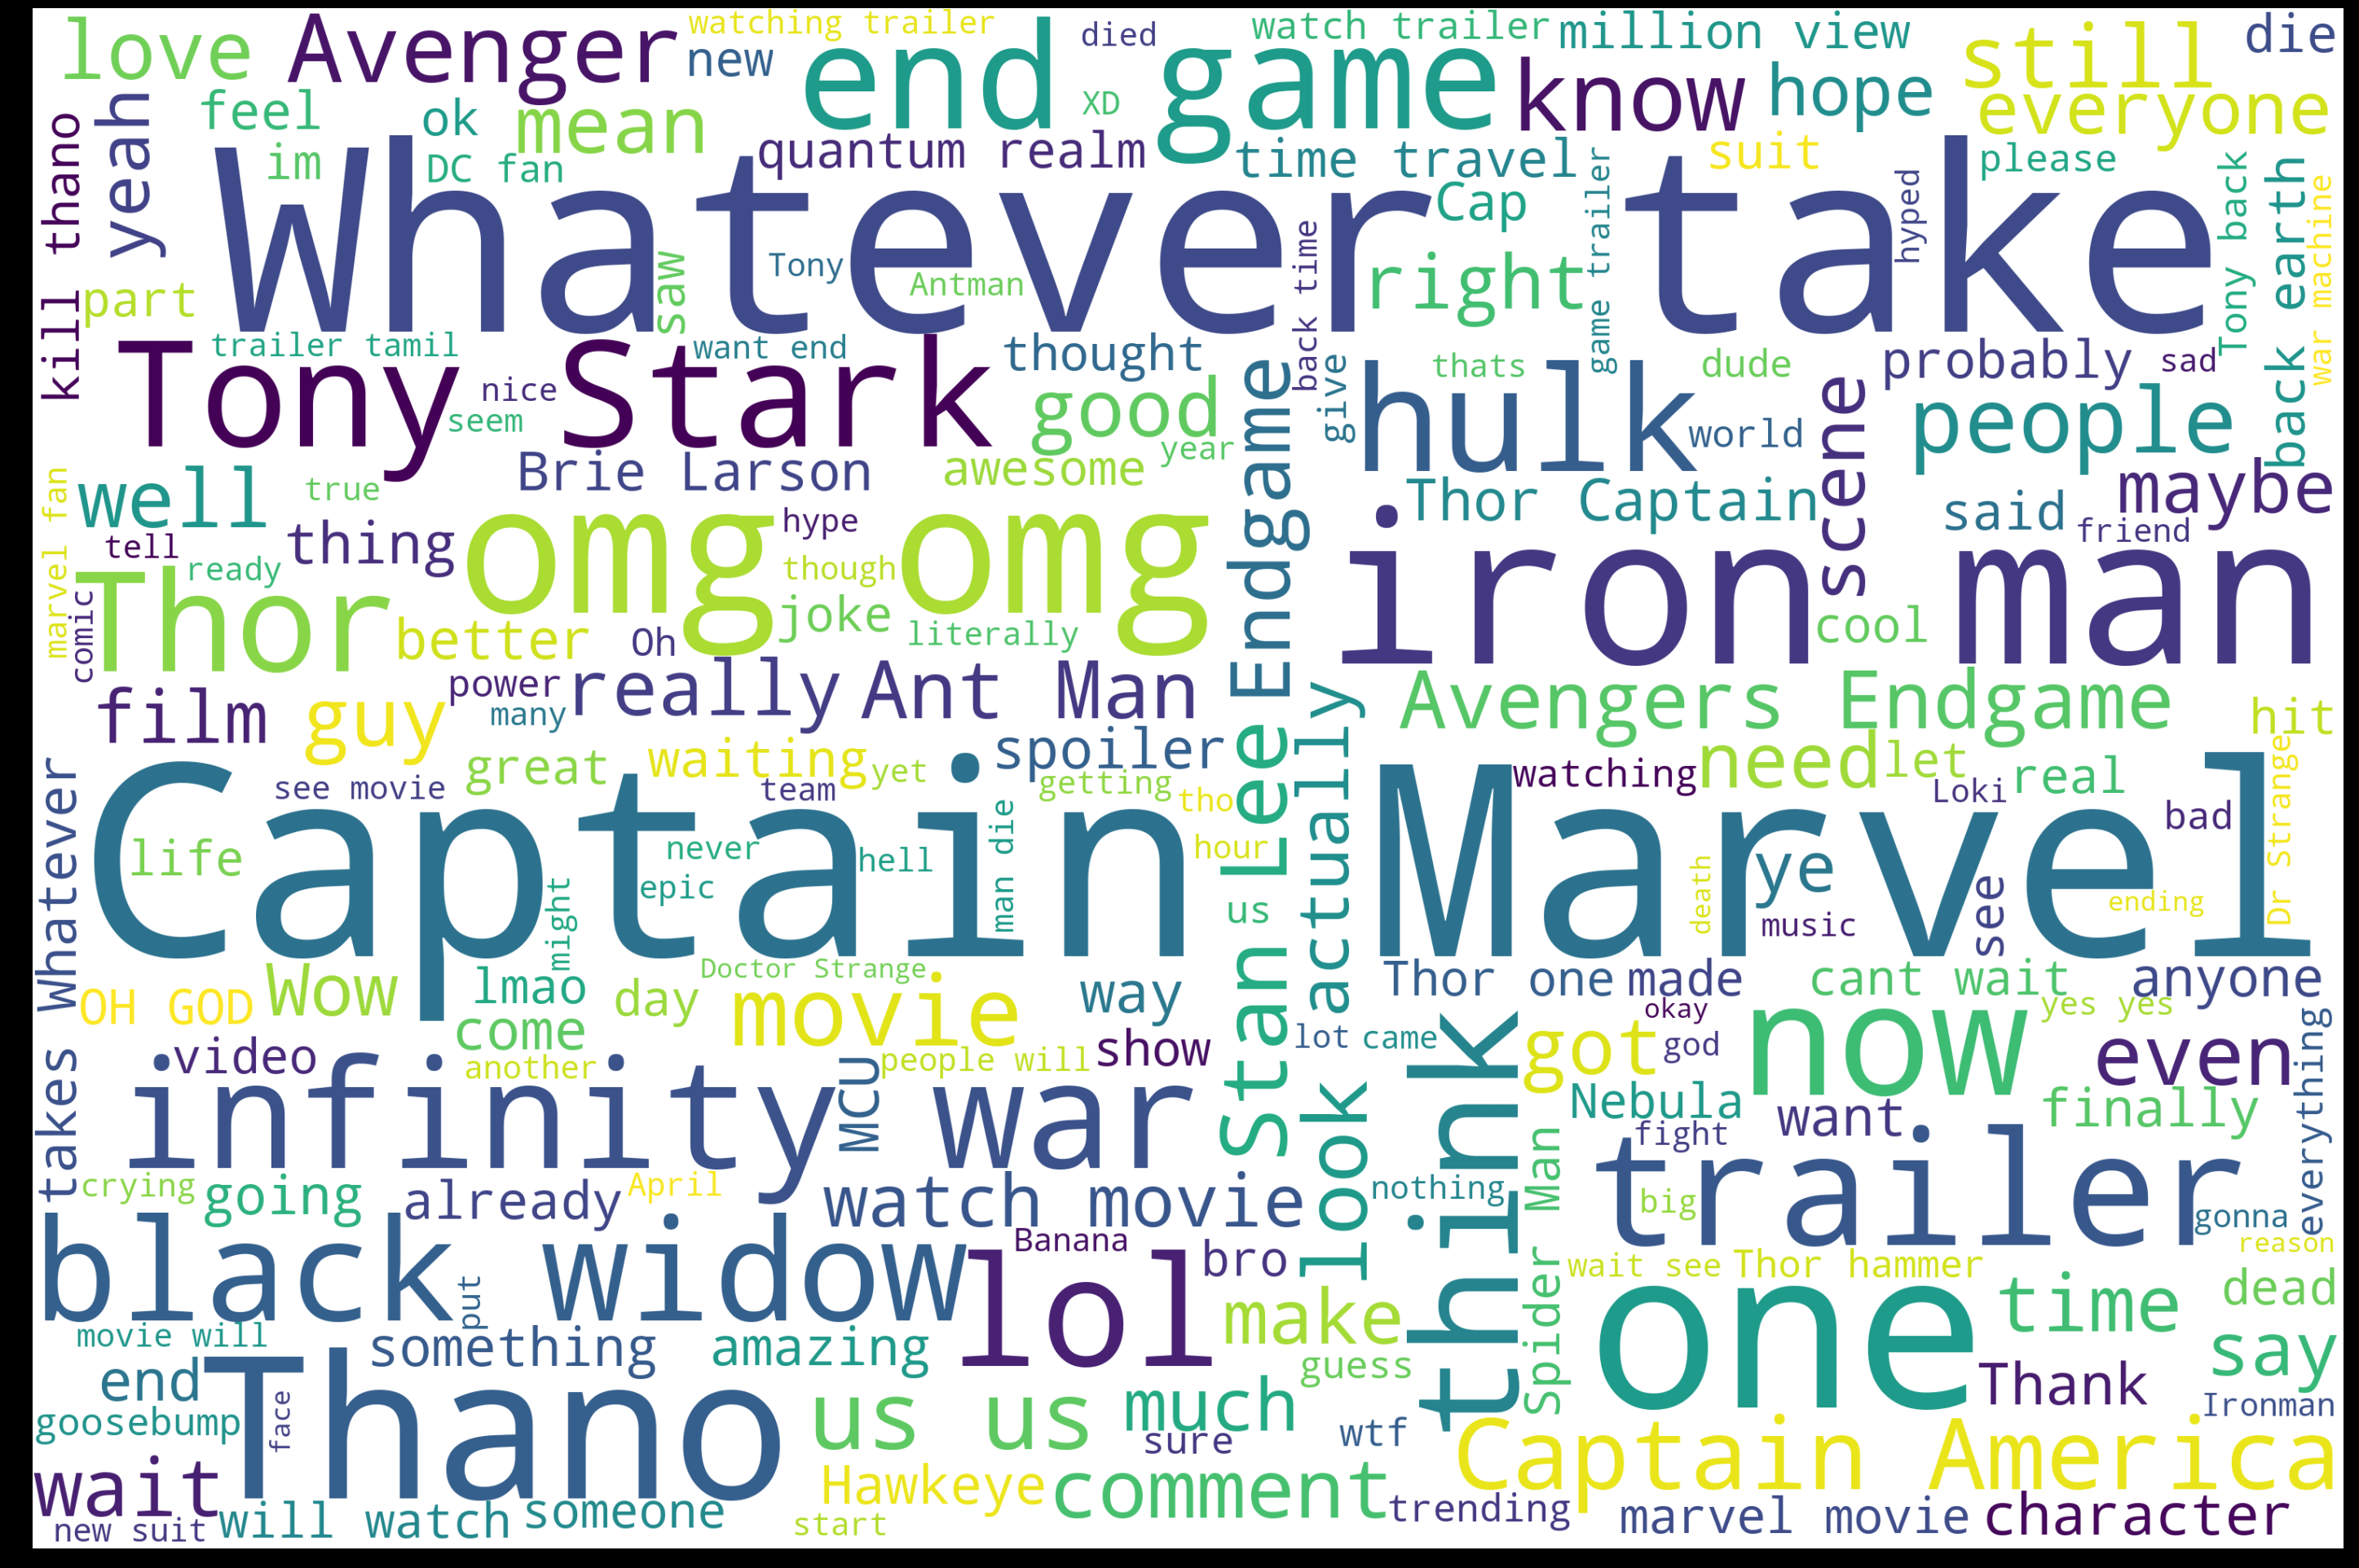

In [9]:
### Add analysis - Wordcloud analysis

createwordcloud(train, 'wordcloud_avengers__alltime.jpg', lower = None)

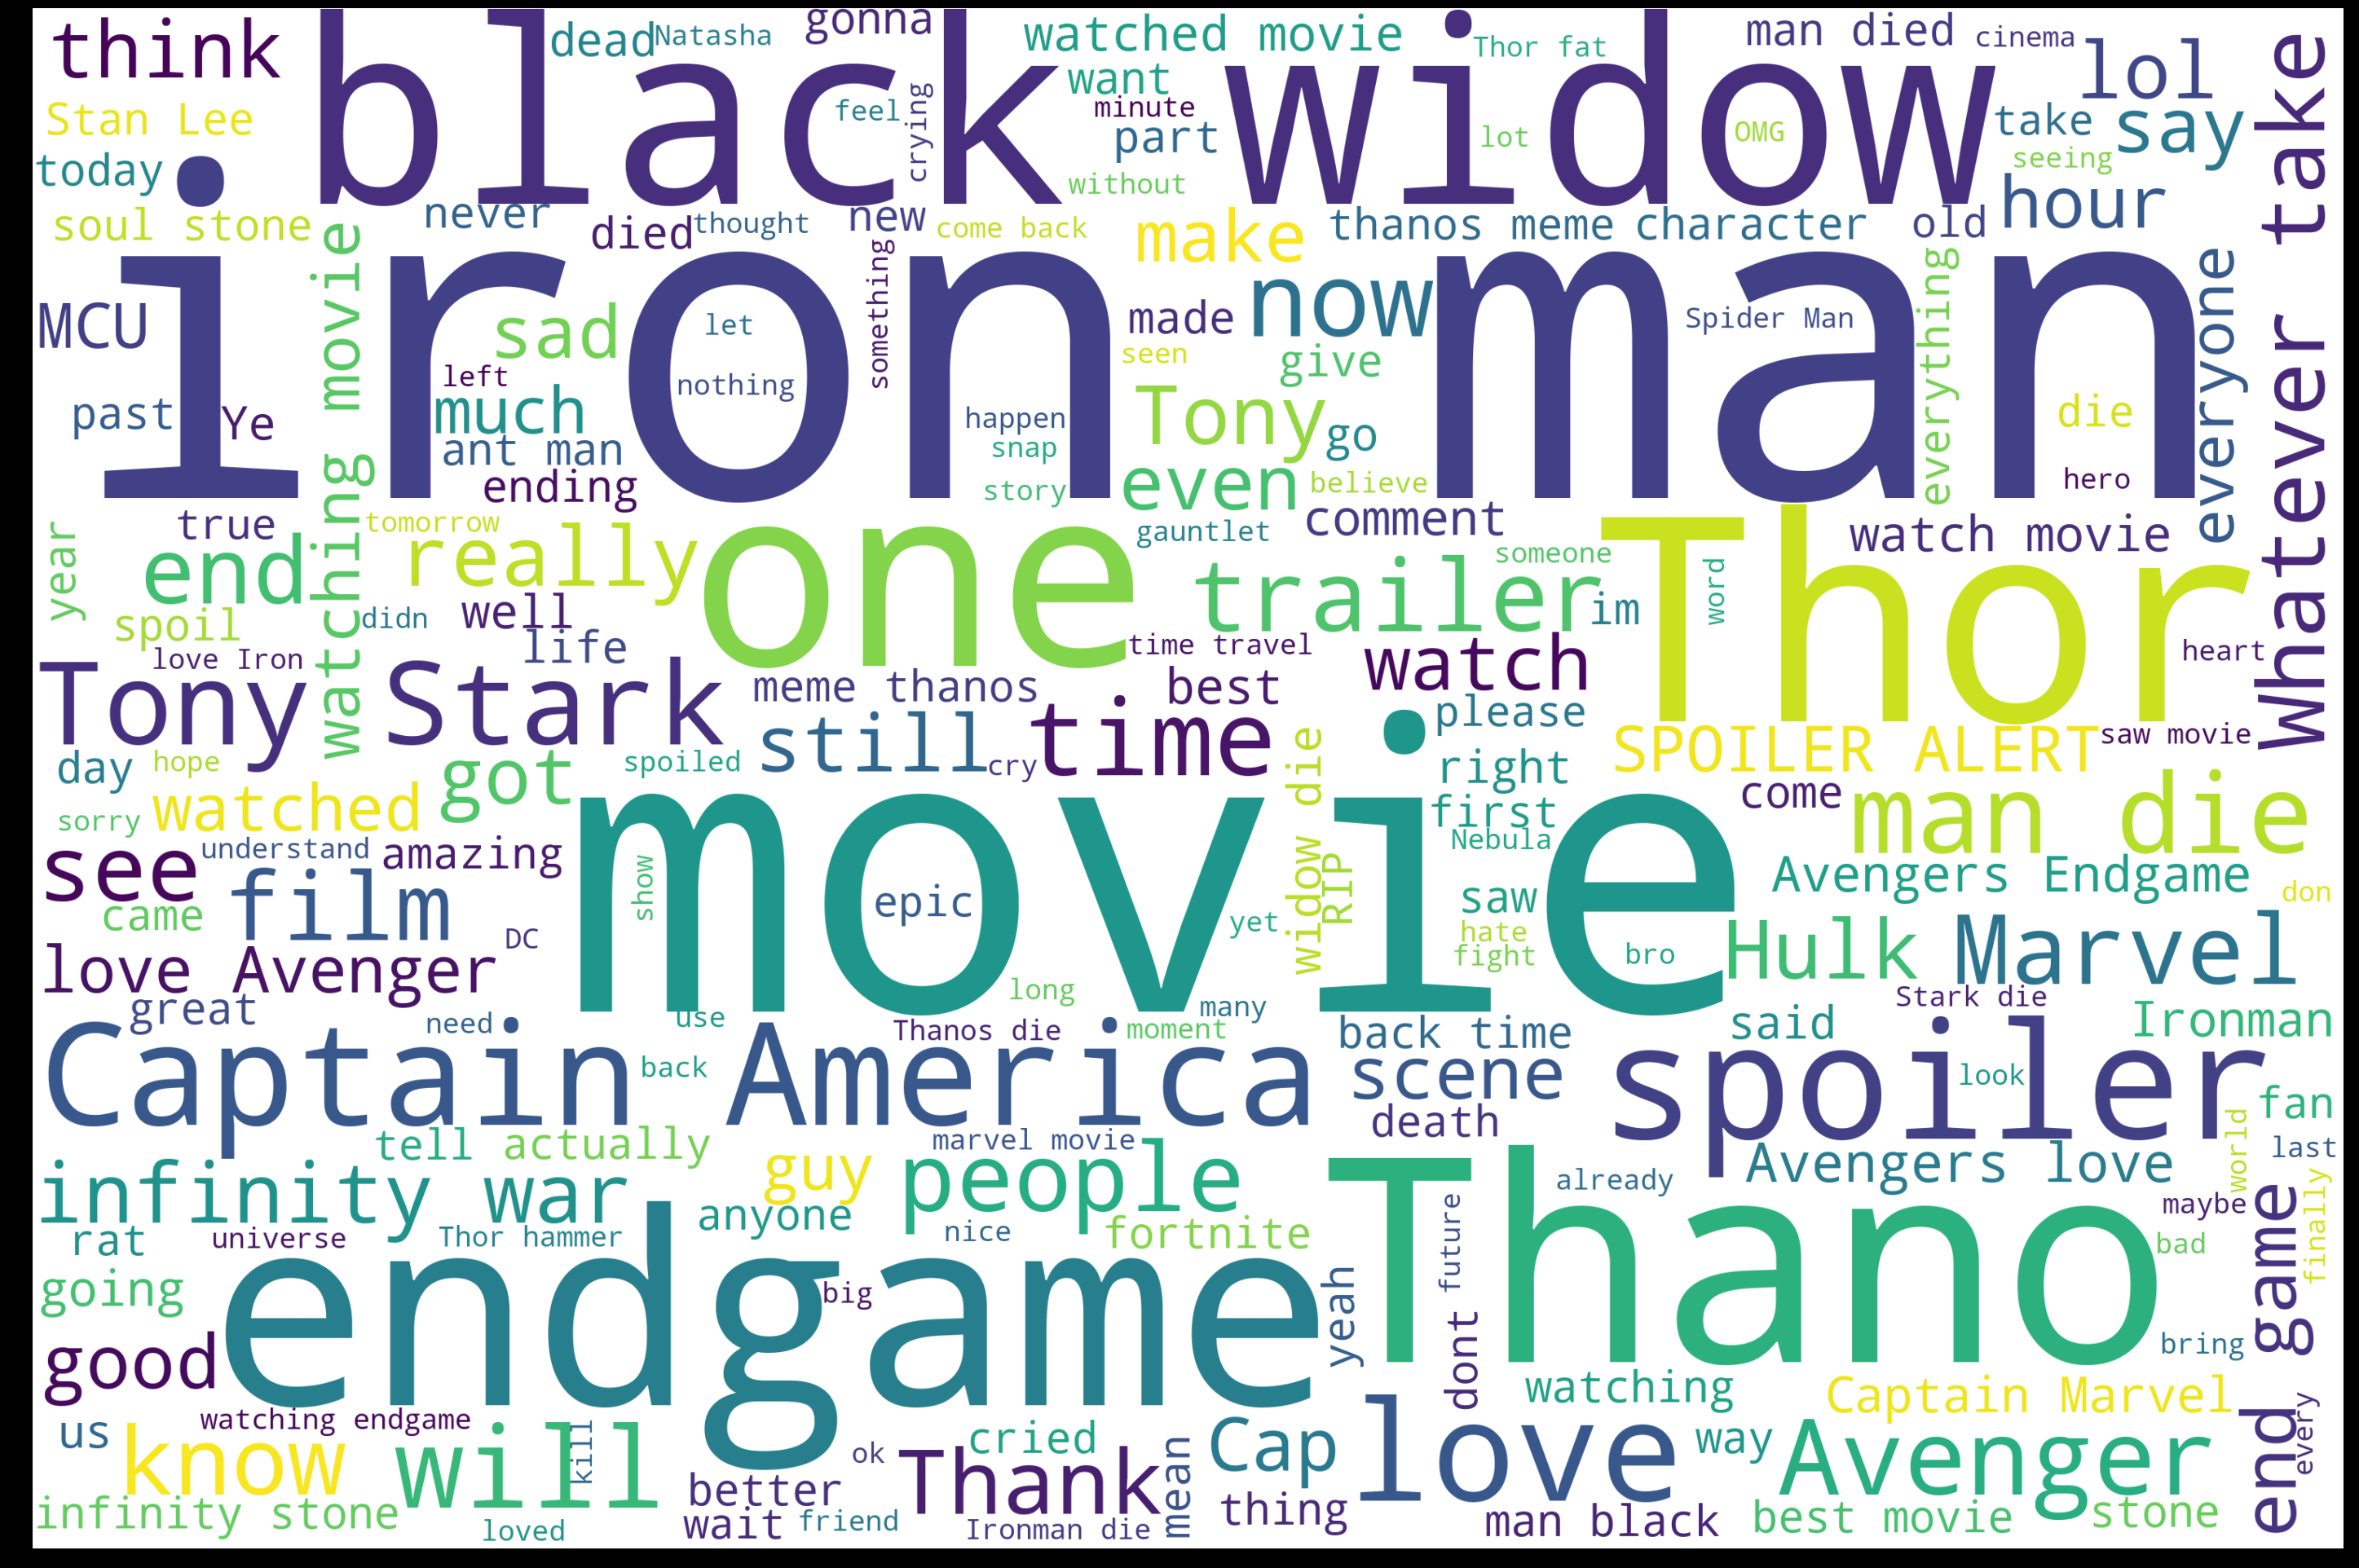

In [10]:
createwordcloud(train.groupby('week').get_group(6), 'wordcloud_avengers__w6.jpg', lower = None)

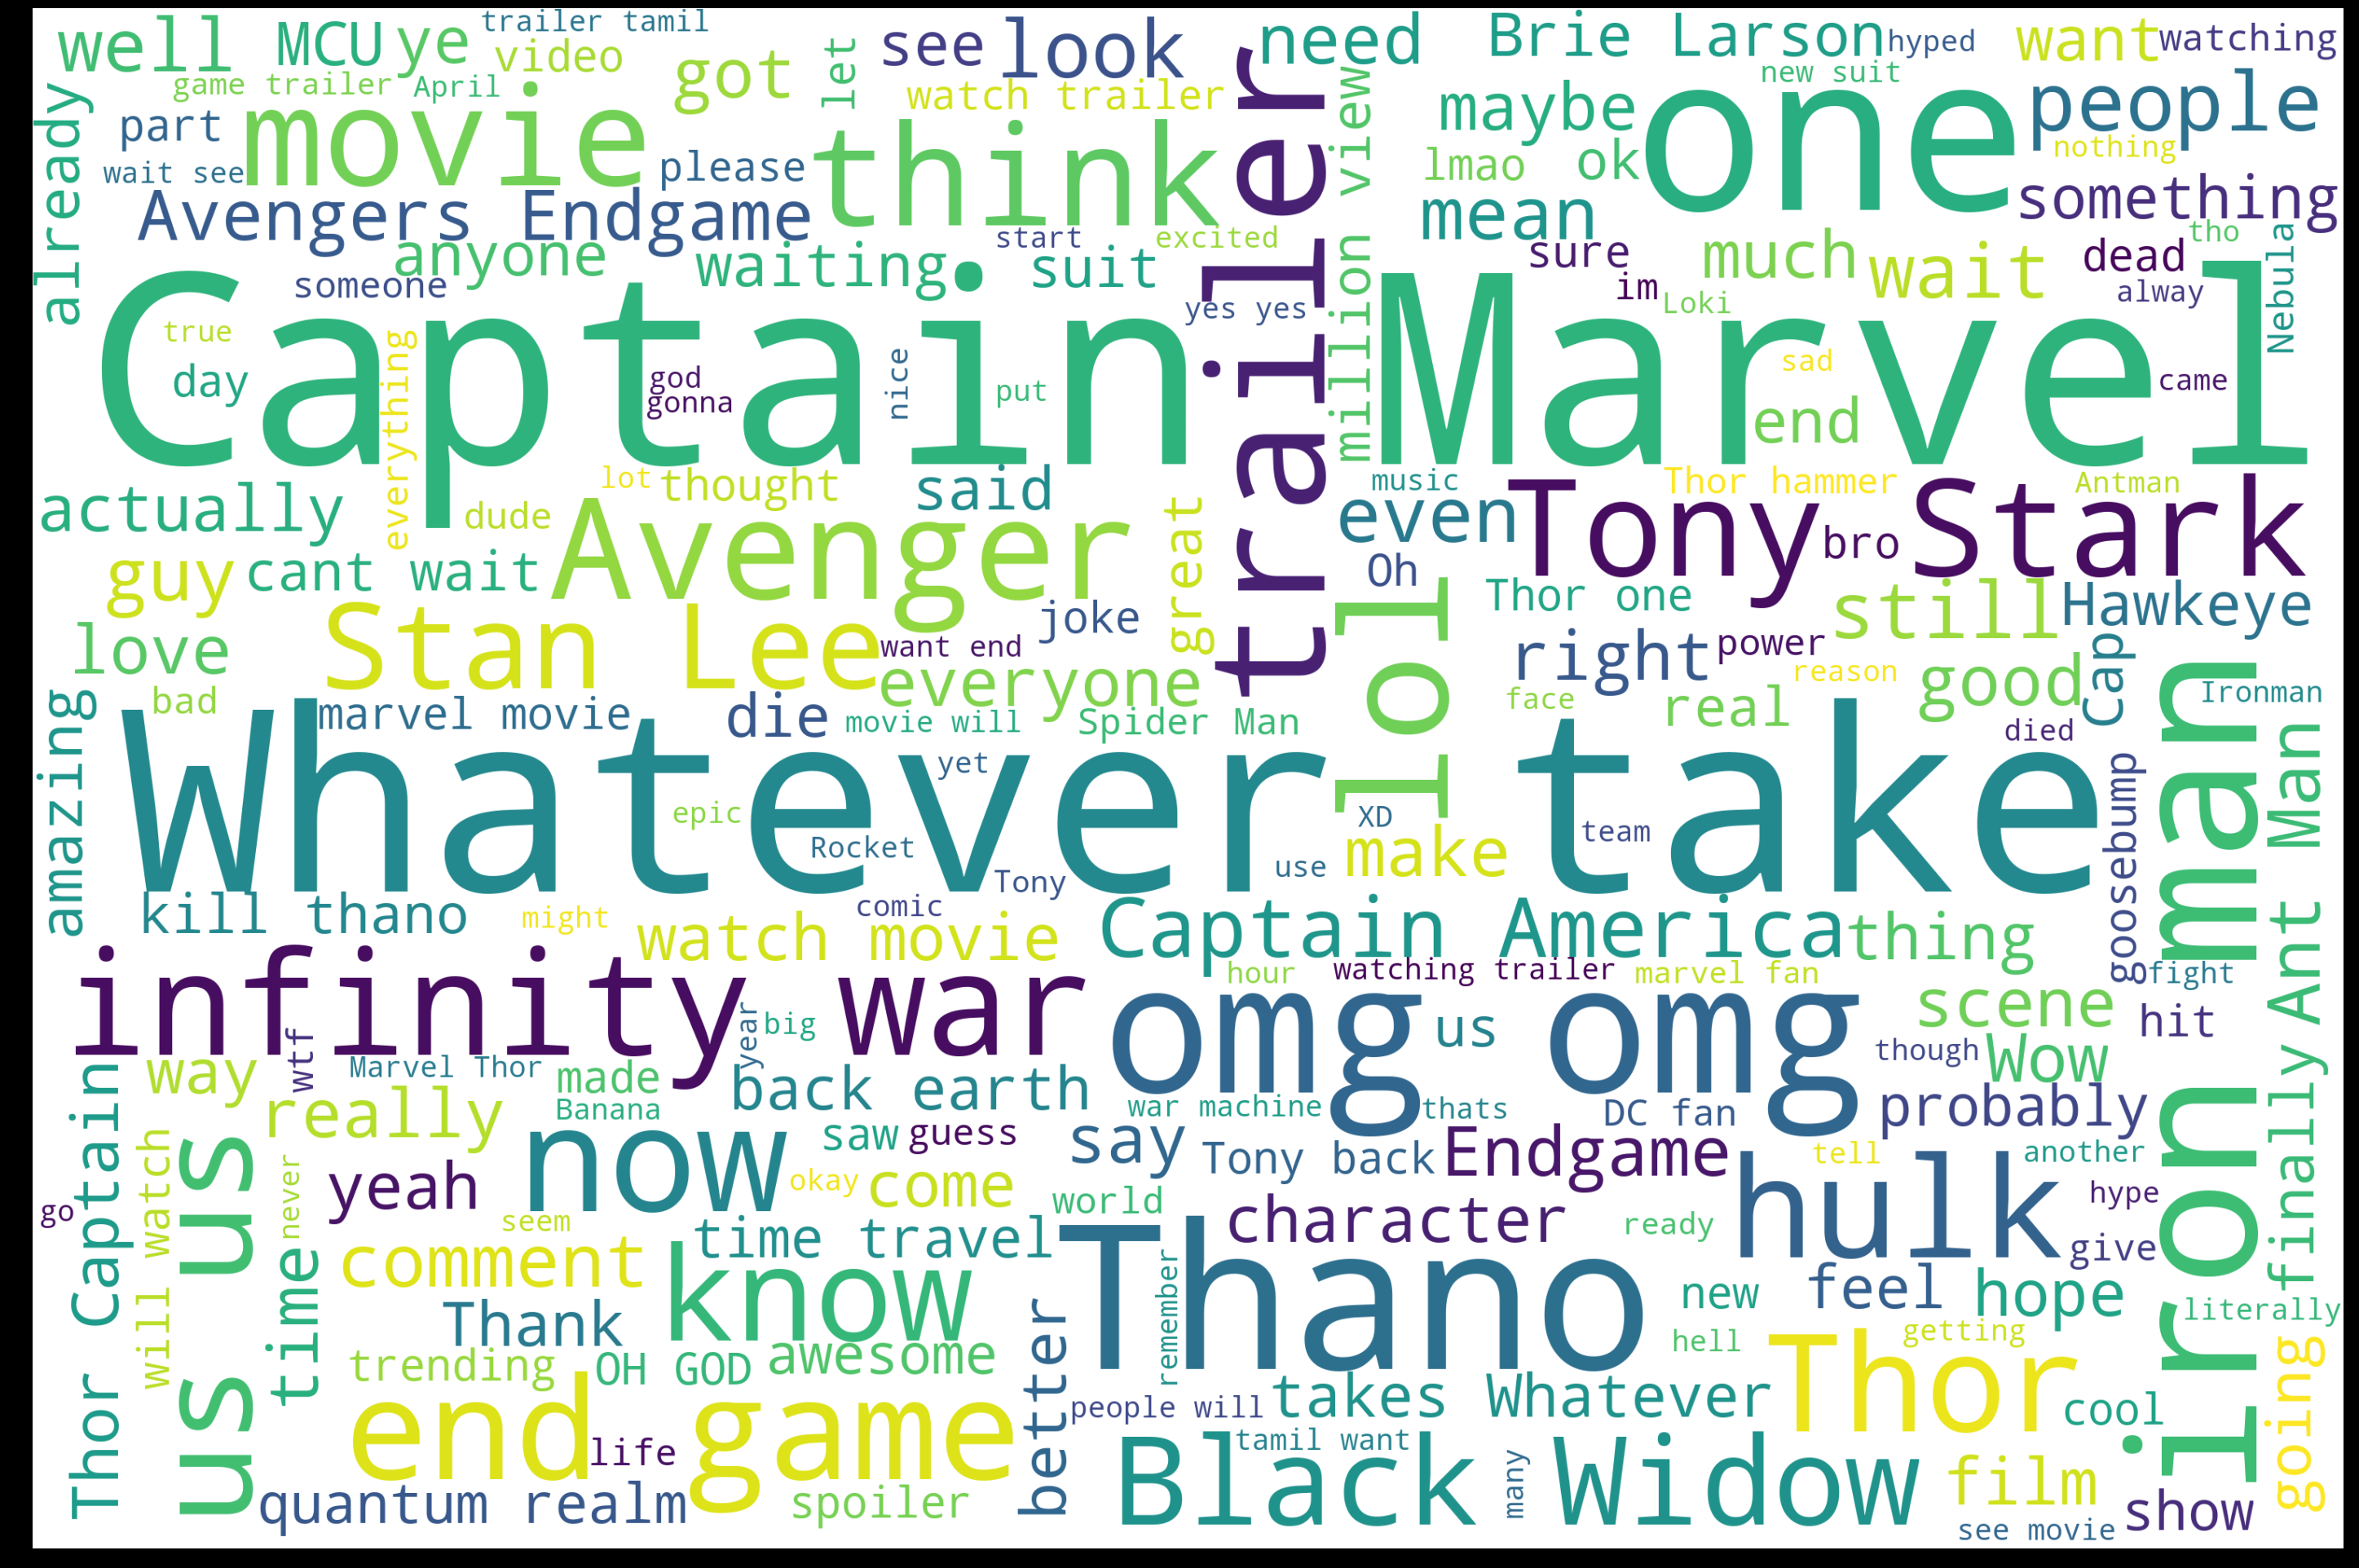

In [11]:
createwordcloud(train[train['week']!=6], 'wordcloud_avengers__before.jpg', lower = None)